In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from imblearn.pipeline import Pipeline, make_pipeline

In [3]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

df=df[['age','default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed']]

#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['contact','month','poutcome']
df_encoded = pd.get_dummies(df['default'], prefix='default', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['default']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

#Changing pandas dataframe to numpy array
X = df

#Normalizing the data
sc = StandardScaler()
X = sc.fit_transform(X)    

#Convert to a pandaframe
X = pd.DataFrame(X, columns = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed'])

X.insert(0, 'ID', range(0, len(X)))
features = pd.merge(df_encoded, X, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [4]:
# create model and wrap into sklearn compatible classifier

train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)

# define hyperparameter search space
C= [0.1,1, 10]
gamma = [1,0.1,0.01,0.001]
kernel = ['linear','rbf']

# create dictionary from search space
grid = dict(
    svc__C=C,
    svc__gamma=gamma,
    svc__kernel=kernel,
)

# create 10-fold cross validation generator
cv = KFold(n_splits=10, shuffle = True , random_state= 23)

# create imbalanced learn pipeline
imba_pipeline = make_pipeline(NearMiss(version=1), svm.SVC(C = 1 ,kernel = 'rbf', gamma = 'scale', probability= True))
#cross_val_score(imba_pipeline, X_train, y_train, scoring='roc_auc', cv=cv)
                              

# create random searcher with 10-fold cv and start tuning process
model_grid = GridSearchCV(estimator=imba_pipeline, param_grid=grid, n_jobs=1, cv=cv, verbose=2, scoring='roc_auc')
grid_res = model_grid.fit(train_features, train_targets)

# summarise grid search info
bestScore = grid_res.best_score_
bestParams = grid_res.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  10.1s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.7s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.4s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.0s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   8.7s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.8s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   8.6s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.2s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.3s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.2s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=  13.2s
[CV] END ..........svc__C=0.1, svc__gamma=1, s

Confusion Matrix:
[[5241 2110]
 [ 270  617]]
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      7351
           1       0.23      0.70      0.34       887

    accuracy                           0.71      8238
   macro avg       0.59      0.70      0.58      8238
weighted avg       0.87      0.71      0.76      8238



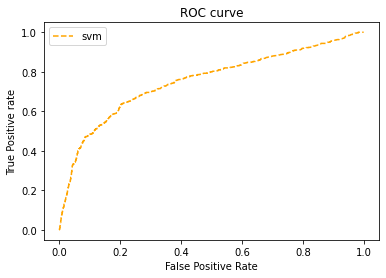

AUC Score: 0.752


In [5]:
predictions = model_grid.predict(test_features)
    
print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))

print("Classification Report")
print(classification_report(test_targets, predictions))
    
#Beginning the plotting of ROC-curve
pred_prob = model_grid.predict_proba(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
#Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='svm')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
#AUC Score
auc_score = roc_auc_score(test_targets, pred_prob[:,1])
print("AUC Score: " + str(np.round(auc_score , 3)))

In [6]:
#Now we set our c, kernel and gamma to the optimal value found in the last grid search
c = 1
gamma = 0.001
kernel = 'rbf'

C: 0.100, train: 0.500, test: 0.500
C: 1.000, train: 0.517, test: 0.515
C: 10.000, train: 0.589, test: 0.592


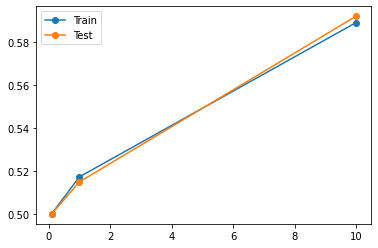

In [8]:
#Check for overfitting with C

# define lists to collect scores
train_scores, test_scores = list(), list()
# define the C to evaluate
values = [0.1,1, 10]
# evaluate the svm for C
for i in values:
    # configure the model
    model = svm.SVC(C= i ,kernel = kernel, gamma = gamma, probability=True, random_state=23 ).fit(
        train_features, train_targets)
    # evaluate on the train dataset
    schatting = model.predict(train_features)
    train_acc = roc_auc_score(train_targets, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('C: %.3f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()


Gamma: 1.000, train: 0.646, test: 0.611
Gamma: 0.100, train: 0.621, test: 0.615
Gamma: 0.010, train: 0.589, test: 0.592
Gamma: 0.001, train: 0.517, test: 0.515


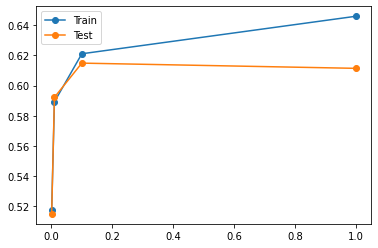

In [9]:
# define lists to collect scores
train_scores, test_scores = list(), list()

values = [1,0.1,0.01,0.001]
# evaluate a gamma
for i in values:
    # configure the model
    model = svm.SVC(C= c ,kernel = kernel, gamma = i, probability=True, random_state = 23).fit(
        train_features, train_targets)
    # evaluate on the train dataset
    schatting = model.predict(train_features)
    train_acc = roc_auc_score(train_targets, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('Gamma: %.3f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

In [ ]:
##VANAF HIER IS DE CODE OUD/FOUT

#Use the parameters of the gridsearch

gamma = 1
c= 1
kernel = 'rbf'

#SVM Classifier
classifier = svm.SVC(C= c ,kernel = kernel, gamma = gamma, probability=True)

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf']}
grid = GridSearchCV(classifier,param_grid,refit=True,scoring='roc_auc', verbose=2)
grid.fit(train_features,train_targets)
print(grid.best_estimator_)
print(grid.best_params_)

grid_predictions = grid.predict(test_features)
print(confusion_matrix(test_targets,grid_predictions))
print(classification_report(test_targets,grid_predictions))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   9.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   6.2s
[CV] END ....................C=0.1, gamma=0.1, 

[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  19.5s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  34.7s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  44.2s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  35.9s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   9.5s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=  10.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   9.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   8.8s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   9.4s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=  38.0s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=  26.3s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=  41.4s
[CV] END ...................

mean cross validation score: 0.885
Confusion Matrix:
[[863  72]
 [226 695]]
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       935
           1       0.91      0.75      0.82       921

    accuracy                           0.84      1856
   macro avg       0.85      0.84      0.84      1856
weighted avg       0.85      0.84      0.84      1856



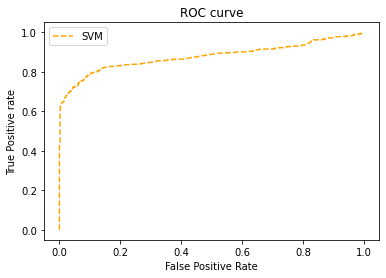

AUC Score: 0.877


In [ ]:
#SVM Classifier
classifier = svm.SVC(C= c ,kernel = kernel, gamma = gamma, probability=True)

k = 10
kf = KFold(n_splits=k, shuffle = True)

    
dt_scores = cross_val_score(classifier, train_features, train_targets, scoring ='roc_auc' ,cv = kf)
print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))
    
classifier.fit(train_features, train_targets)

predictions = classifier.predict(test_features)

print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))

print("Classification Report")
print(classification_report(test_targets, predictions))
    
#Beginning the plotting of ROC-curve
pred_prob = classifier.predict_proba(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
#Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='SVM')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
#AUC Score
auc_score = roc_auc_score(test_targets, pred_prob[:,1])
print("AUC Score: " + str(np.round(auc_score , 3)))